In this case, we had masks created with cellpose. The masks were divided in two types: one type contained individual organelles. The other mask contain the cells (each cell can have up to 6 organelles). In this notebook, we're selecting only the masks with invidual organelles. Sometimes, in other notebooks, we use the cell mask to cut the set of organelles per cell. 

In [20]:
# Import required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.measure import label, regionprops, regionprops_table
from scipy.stats import gaussian_kde, ks_2samp
import torch
from pathlib import Path
from tqdm import tqdm
import atomai as aoi
import seaborn as sns


In [2]:
# Some helper functions
def make_square(img,box_size):
  y = (box_size - img.shape[0])
  if y%2==0:
    y1=y2=y/2
  else:
    y1 = np.ceil(y/2)
    y2 = y - y1
  x = (box_size - img.shape[1])
  if x%2==0:
    x1=x2=x/2
  else:
    x1 = np.ceil(x/2)
    x2 = x - x1
  
  return np.pad(img,((int(y1),int(y2)),(int(x1),int(x2))),mode='constant',constant_values=0)
  
def normalize_01(inp: np.ndarray):
    """
    normalize image range from 0 to 1
    """
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def rotate_and_pad_img(sample,pixels,box_size,rotate=False):
    """
    Function to crop, rotate, and pad a labelled section of a segmented image
    Args:
      sample (label)
      Sample from labelled image

      pixels (array)
      image array, H x W, single-channel
      
      box_size (int)
      Size of final square image dimension
    Returns square-padded image array
    """
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    target_channel = pixels[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    target_channel = (target_channel > 0) * sample.filled_image
    if rotate == True:
      rotated_image = sk.transform.rotate(target_channel, -angle-90, resize = True)
      H, W = rotated_image.shape
      image_center = rotated_image[max([int(H/2-width/2), 0]):int(H/2+width/2)+1,max([0,int(W/2-length/2)]):int(W/2+length/2)]
      return make_square(np.ones(sample.filled_image.shape)*(image_center),box_size)
    else:
      return make_square(np.ones(sample.filled_image.shape)*(target_channel),box_size)

def mask2stack(ccm_mask,cell_mask=None,window_size=115,rotate=False):
  """
  Function to ingest cell mask and carboxysome mask or pixel intensity and output an array of padded submasks
  Args:
  cell_mask (labelled image)
  
  ccm_mask (labelled image or pixel intensity array)

  window_size (int)
  Size of padded image
  """

  if cell_mask.any:
    labelled_image = label(cell_mask)
    feature_table = regionprops(labelled_image)
    CellSize_label = []
        # remove debris
    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
                CellSize_label.append(i.label)
    subimgs = []
    for i in np.argsort(CellSize_label):
        sample = feature_table[CellSize_label[i]-1]
        cell = rotate_and_pad_img(sample,cell_mask,window_size,rotate)
        ccm = rotate_and_pad_img(sample,ccm_mask,window_size,rotate)
        #ccm = np.ones(ccm.shape) * (ccm >0.01)
        subimgs.append(ccm)
  else:
    labelled_image = label(ccm_mask)
    feature_table = regionprops(labelled_image)
    subimgs = [make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size) for sample in feature_table]
  return np.stack(subimgs,axis=0)

In [3]:
if os.path.exists(r'../data/subimg.npy'):
    subimg = np.load(r'../data/subimg.npy')
else:
    directory = r'../data'
    files = Path(directory).rglob('*.czi')
    mask_stack = list()
    for f in tqdm(list(files)):
        cell_mask = np.load(str(f)[0:-4] + '_cell.npy')
        ccm_mask = np.load(str(f)[0:-4] + '_ccm.npy')
        mask_stack.append(mask2stack(ccm_mask,cell_mask,rotate=False))
    subimg = np.vstack(mask_stack)
    np.save(r'../data/subimg.npy',subimg)
subimg.shape

(62284, 115, 115)

**Plotting some of the subimages**

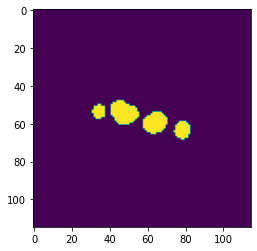

In [4]:
plt.imshow(subimg[4000,:,:])

In [5]:
torch.cuda.is_available()

True

In [6]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='GeForce GTX 1660 Ti', major=7, minor=5, total_memory=6144MB, multi_processor_count=24)

**rVAE**

In [7]:
train = False

if train == True:
    in_dim = (subimg.shape[1], subimg.shape[2])
    depth = 256
    batch = 10
    #


    rvae = aoi.models.jrVAE(in_dim, latent_dim=2, discrete_dim=[5],translation= True,
                            numlayers_encoder=3, numhidden_encoder=depth,
                            numlayers_decoder=3, numhidden_decoder=depth,
                        Skip = True)

    rvae.fit(subimg,training_cycles=100,batch_size=batch)
    rvae.save_model("jrvae")
    rvae.save_weights("jrvae-w")

else:
    rvae= aoi.models.load_model(f"../models/jrvae.tar")

Epoch: 1/100, Training loss: 141.8300
Epoch: 2/100, Training loss: 108.8495
Epoch: 3/100, Training loss: 97.6789
Epoch: 4/100, Training loss: 89.6721
Epoch: 5/100, Training loss: 85.6335
Epoch: 6/100, Training loss: 84.6569
Epoch: 7/100, Training loss: 84.0205
Epoch: 8/100, Training loss: 83.4732
Epoch: 9/100, Training loss: 83.3158
Epoch: 10/100, Training loss: 82.9609
Epoch: 11/100, Training loss: 82.7407
Epoch: 12/100, Training loss: 82.5200
Epoch: 13/100, Training loss: 82.3940
Epoch: 14/100, Training loss: 82.2562
Epoch: 15/100, Training loss: 82.1775
Epoch: 16/100, Training loss: 82.0391
Epoch: 17/100, Training loss: 81.9389
Epoch: 18/100, Training loss: 81.7260
Epoch: 19/100, Training loss: 81.6617
Epoch: 20/100, Training loss: 81.6444
Epoch: 21/100, Training loss: 81.3962
Epoch: 22/100, Training loss: 81.3409
Epoch: 23/100, Training loss: 81.2906
Epoch: 24/100, Training loss: 81.1529
Epoch: 25/100, Training loss: 81.0917
Epoch: 26/100, Training loss: 81.0282
Epoch: 27/100, Trai

NameError: name 'aoi' is not defined

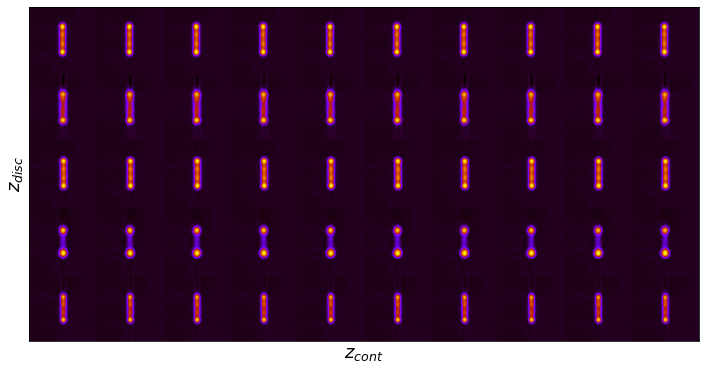

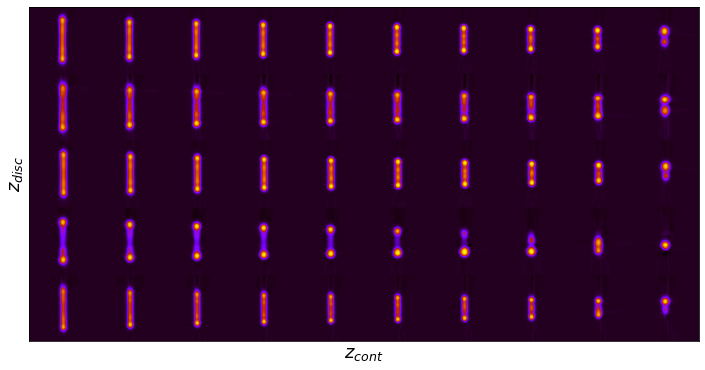

In [12]:
for i in range(2):
    rvae.manifold_traversal(i, origin="upper")

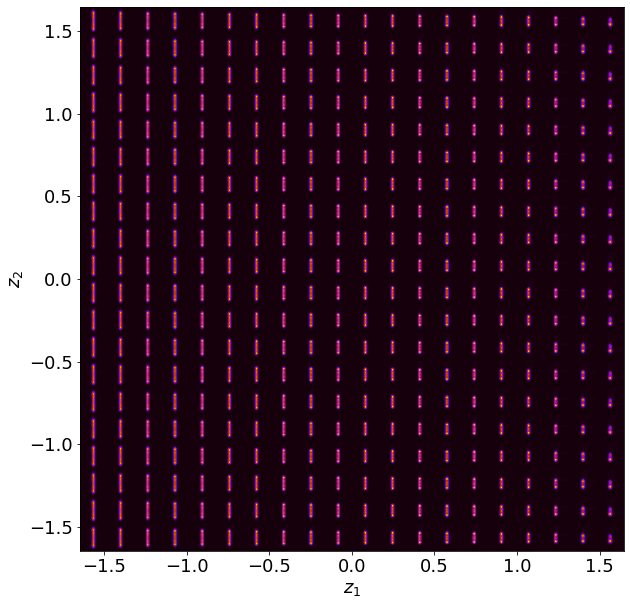

array([[0.00947716, 0.00947039, 0.00946259, ..., 0.01030843, 0.01031778,
        0.01032756],
       [0.00952853, 0.00952409, 0.00951934, ..., 0.01031613, 0.010326  ,
        0.01033621],
       [0.00957458, 0.00957104, 0.00956773, ..., 0.01032454, 0.01033482,
        0.01034534],
       ...,
       [0.00912425, 0.00915829, 0.00919593, ..., 0.01116625, 0.01116757,
        0.01117578],
       [0.0092318 , 0.00927345, 0.00931783, ..., 0.01118014, 0.01117698,
        0.01118047],
       [0.00935267, 0.0093989 , 0.0094464 , ..., 0.01120173, 0.0111945 ,
        0.01119313]])

In [14]:
#rvae.manifold2d(d=10, l1=[-4,1], l2=[-3,3], cmap="viridis");
rvae.manifold2d(d=20)
# rvae.manifold2d(d=24, cmap="viridis");




In [15]:
directory = r'../data'
files = Path(directory).rglob('*.czi')
mask_stack = list()
Timepoints = list()
Induction = list()
stacks = [list() for i in range(10)]
for f in tqdm(list(files)):
    if 'Control' in str(f):
        IPTG = 0
    elif 'Induced' in str(f):
        IPTG = 1
    else:
        print('no folder?')
    folder = os.path.basename(os.path.dirname(f))
    Time = int(folder)
    cell_mask = np.load(str(f)[0:-4] + '_cell.npy')
    ccm_mask = np.load(str(f)[0:-4] + '_ccm.npy')
    if IPTG == 0 and Time == 4:
        imgset = 0
    elif IPTG == 0 and Time == 8:
        imgset = 1
    elif IPTG == 0 and Time == 24:
        imgset = 2
    elif IPTG == 0 and Time == 48:
        imgset = 3
    elif IPTG == 0 and Time == 72:
        imgset = 4
    elif IPTG == 1 and Time == 4:
        imgset = 5
    elif IPTG == 1 and Time == 8:
        imgset = 6
    elif IPTG == 1 and Time == 24:
        imgset = 7
    elif IPTG == 1 and Time == 48:
        imgset = 8
    elif IPTG == 1 and Time == 72:
        imgset = 9
    stacks[imgset].append(mask2stack(ccm_mask,cell_mask,rotate=False))
subimgs = [np.vstack(x) for x in stacks]


100%|██████████| 96/96 [01:29<00:00,  1.07it/s]


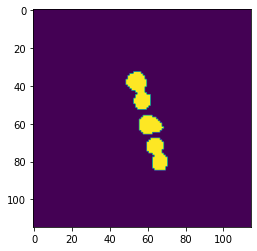

In [13]:
plt.imshow(subimgs[0][3000])

In [14]:
len(stacks)

10

In [15]:
subimgs[0].shape

(4389, 115, 115)

In [16]:
results = [rvae.encode(x) for x in subimgs]

In [17]:
titles = ['Control 4','Control 8','Control 24','Control 48','Control 72','Induced 4','Induced 8','Induced 24','Induced 48','Induced 72']
params = ['Angle','x shift','y shift','L1','L2']

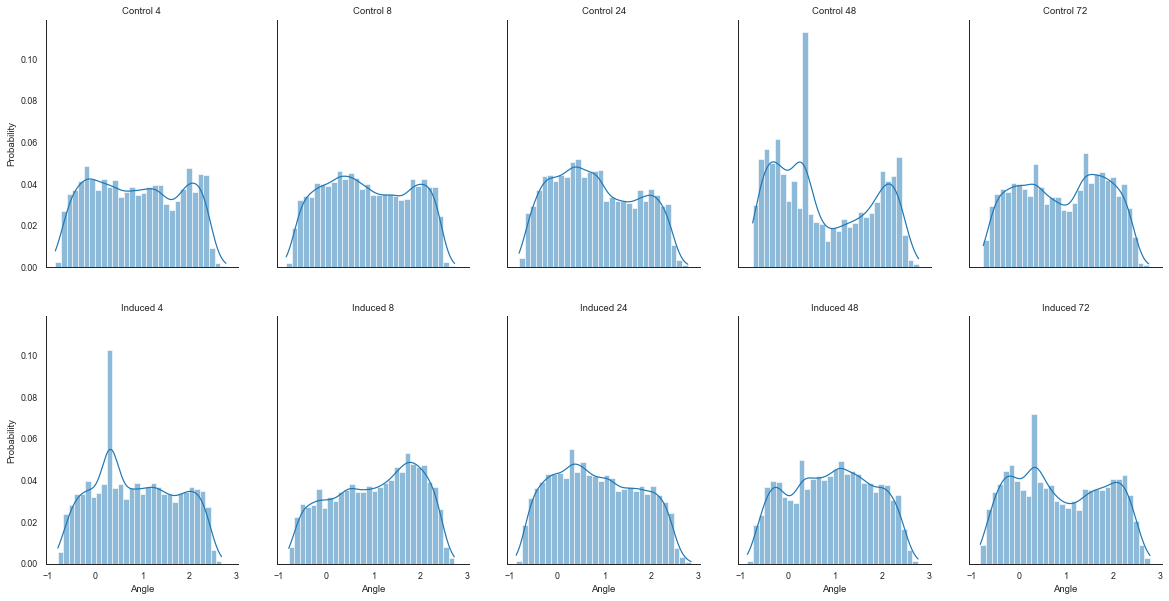

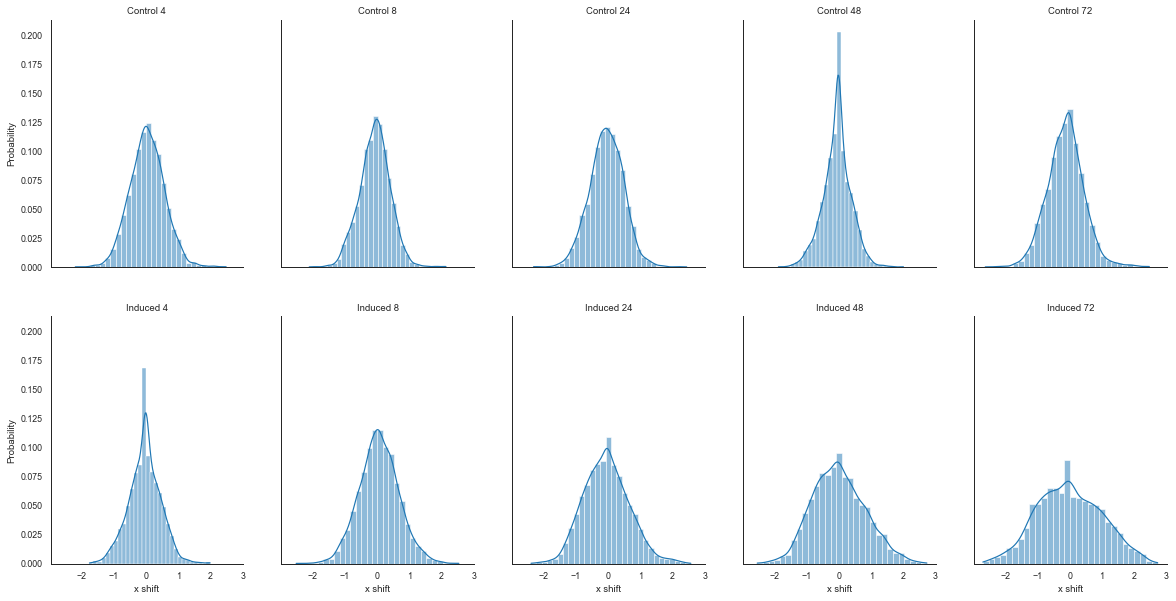

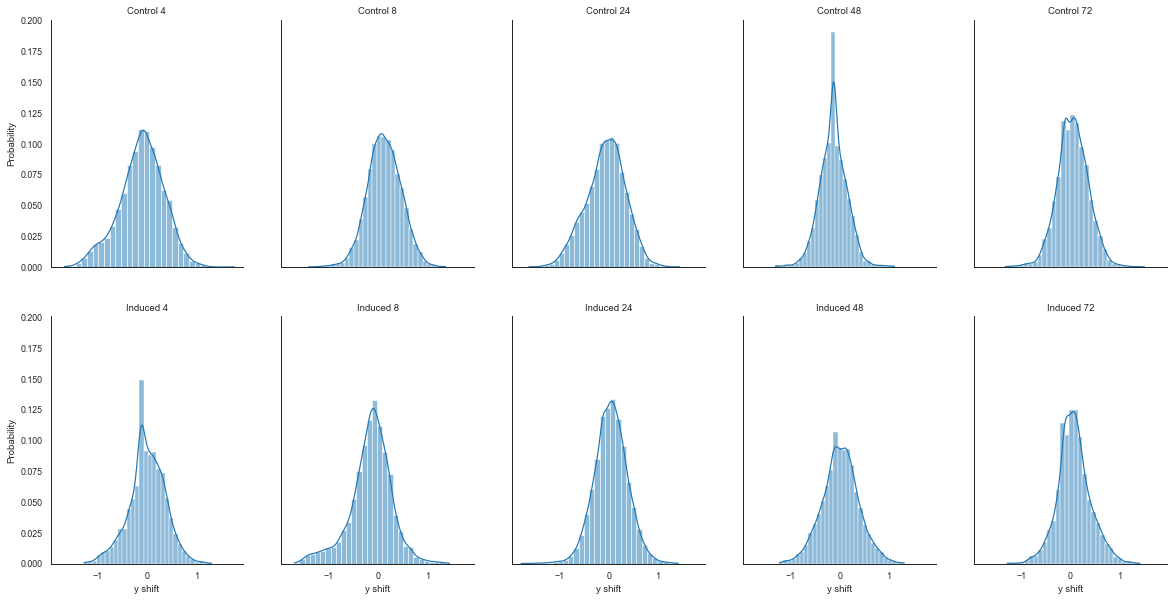

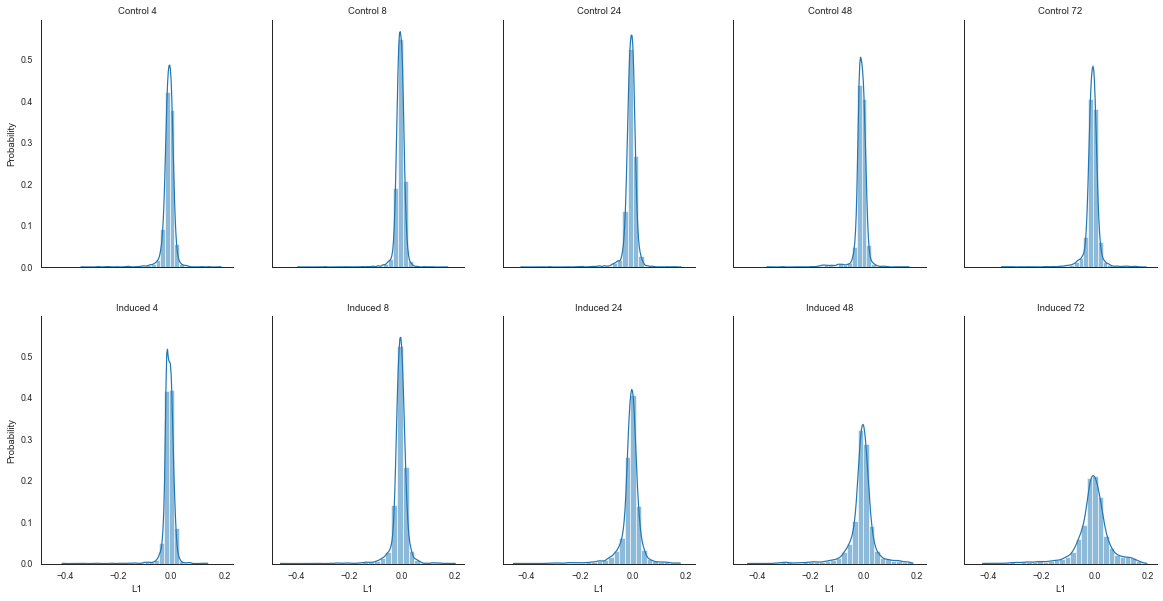

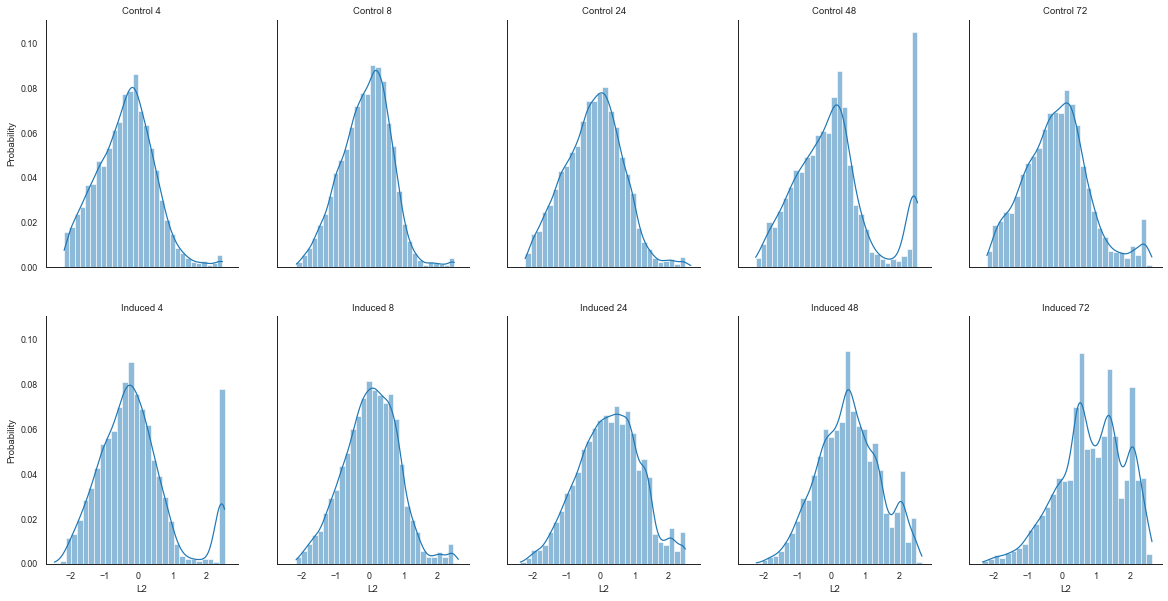

In [18]:
sns.set_context('paper')
sns.set_style('white')
for i,param in enumerate(params):
    f, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(20, 10))
    for j, ax in zip(range(10),axes.ravel()):
        sns.histplot(results[j][0][:,i],bins=30,stat='probability',kde=True,ax=ax)
        ax.set_title(titles[j])
        ax.set_xlabel(param)
    sns.despine()

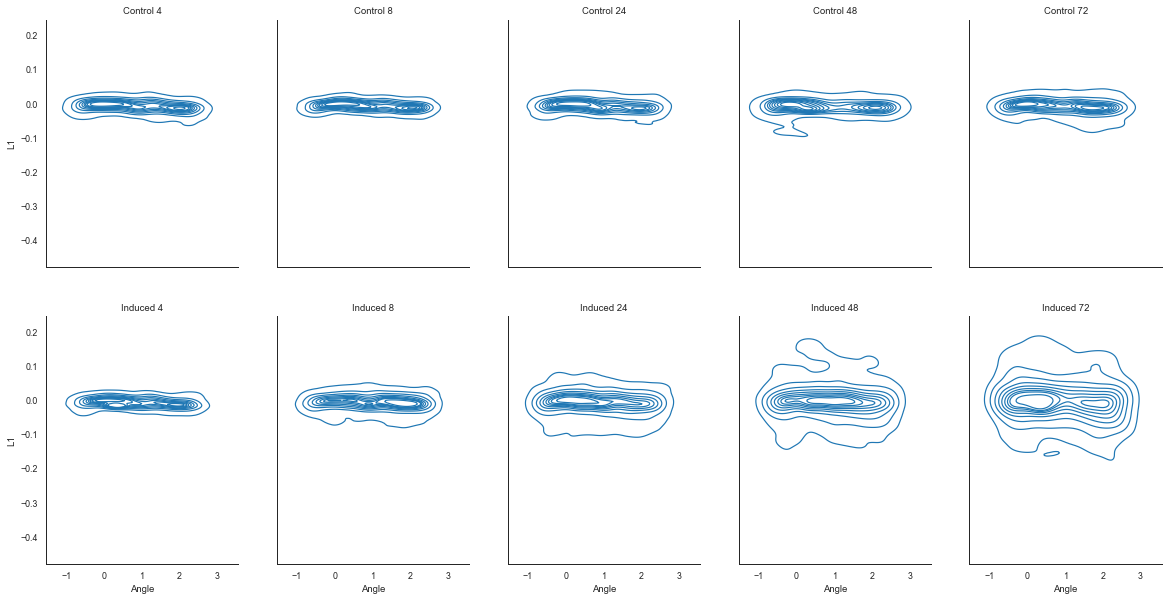

In [19]:
sns.set_context('paper')
sns.set_style('white')

f, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(20, 10))
for j, ax in zip(range(10),axes.ravel()):
    sns.kdeplot(x=results[j][0][:,0],y=results[j][0][:,3],ax=ax)
    ax.set_title(titles[j])
    ax.set_xlabel('Angle')
    ax.set_ylabel('L1')
sns.despine()

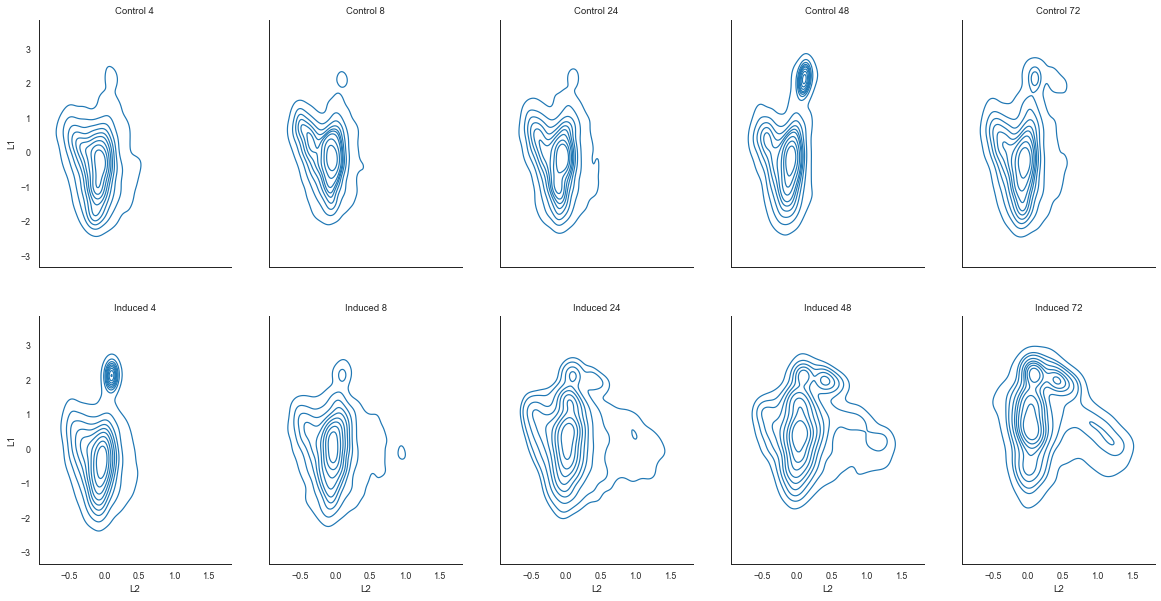

In [20]:
sns.set_context('paper')
sns.set_style('white')

f, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(20, 10))
for j, ax in zip(range(10),axes.ravel()):
    sns.kdeplot(x=results[j][0][:,3],y=results[j][0][:,4],ax=ax)
    ax.set_title(titles[j])
    ax.set_xlabel('L2')
    ax.set_ylabel('L1')
sns.despine()

# Conduct Two-sample Kolmogorov–Smirnov test

In [57]:
alpha = 0.001
df = pd.DataFrame(columns=['Time','Latent parameter','D_crit','Alpha','D','p','Significance'])
timepoints=[4,8,24,48,72]
for i,param in enumerate(params):
    for j in range(5):
        D = np.sqrt(-np.log(alpha/2)*((1+(len(results[j][0][:,i])/len(results[j+5][0][:,i])))/(2*len(results[j+5][0][:,i]))))     
        ks ,p = ks_2samp(results[j][0][:,i],results[j+5][0][:,i])
        if ks > D and p < alpha:
            significance = 'Significant'
        else:
            significance = 'ns'
        df = df.append(pd.DataFrame([[timepoints[j],param,D,alpha,ks,p,significance]],columns=['Time','Latent parameter','D_crit','Alpha','D','p','Significance']),ignore_index=True)

df


,Time,Latent parameter,D_crit,Alpha,D,p,Significance
0,4,Angle,0.043337,0.001,0.055185,4.248563e-06,Significant
1,8,Angle,0.032061,0.001,0.091487,4.440892e-16,Significant
2,24,Angle,0.025325,0.001,0.031582,3.021353e-04,Significant
3,48,Angle,0.029303,0.001,0.191798,3.774758e-15,Significant
4,72,Angle,0.045598,0.001,0.049193,4.527546e-06,Significant


1.7 -2.0
1.7 -1.0
1.7 0.0
1.7 1.0
1.7 1.0


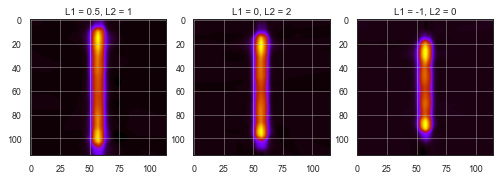

In [22]:
# L1 = 1.7
# L2 = -2
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -2 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded1 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = -1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = -1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded2 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 0
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 0 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded3 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])

# L1 = 1.7
# L2 = 1
lv1_vals = np.linspace(1.7,1.8,1)
lv2_vals = np.zeros_like(lv1_vals)
lv2_vals = 1 + lv2_vals
lv_vals = lv_vals = np.concatenate((lv1_vals[:, None], lv2_vals[:, None]), axis=-1)
decoded4 = rvae.decode(lv_vals)
print(lv1_vals[0],lv2_vals[0])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,7,1)
ax.imshow(decoded1[0], cmap="gnuplot")
ax.set_title('L1 = 0.5, L2 = 1')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,7,2)
ax.imshow(decoded2[0], cmap="gnuplot")
ax.set_title('L1 = 0, L2 = 2')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)

ax = fig.add_subplot(1,7,3)
ax.imshow(decoded3[0], cmap="gnuplot")
ax.set_title('L1 = -1, L2 = 0')
# ax.set_xlim(0,35)
ax.grid(alpha = 0.5)


